In [1]:
from utils import *
import matplotlib.pyplot as plt
import torch
import numpy as np
import dsprites
import models
import os
import cem.train.training as training
torch.manual_seed(42)
np.random.seed(42)

/Users/oscar/miniconda3/envs/project/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/oscar/miniconda3/envs/project/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2D1B8D5C-7891-3680-9CF9-F771AE880676> /Users/oscar/miniconda3/envs/project/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <2D68CDC2-76C0-3D65-B41E-4C9217A6016F> /Users/oscar/miniconda3/envs/project/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
device = (
  "cuda"
  if torch.cuda.is_available()
  else "mps"
  if torch.backends.mps.is_available()
  else "cpu"
)
print(f"Using {device} device")

Using mps device


# Net2Vec Interventions

## DSPRITES

In [3]:
dsprites_model = models.Model(1, 64, 64, 12)

if os.path.exists('dsprites_model.pth'):
  dsprites_model.load_state_dict(torch.load('dsprites_model.pth'))
else:
    train(dsprites_model, dsprites.train_dl, dsprites.val_dl, epochs=8)
    torch.save(dsprites_model.state_dict(), 'dsprites_model.pth')
dsprites_model.to(device)

Model(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (postconv1): Sequential(
    (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (postconv2): Sequential(
    (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (postconv3): Sequential(
    (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (postconv4): Sequential(
    (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (out): Sequential(
    (0): Flatten(start_dim=1, end

In [4]:
dsprite_concept_classifier = models.LinearModels(64, 7)

if os.path.exists('dsprites_concept_classifier.pth'):
  dsprite_concept_classifier.load_state_dict(torch.load('dsprites_concept_classifier.pth'))
else:
  train_concept_classifier(dsprites_model, dsprite_concept_classifier, dsprites.train_dl, dsprites.val_dl)
  torch.save(dsprite_concept_classifier.state_dict(), 'dsprites_concept_classifier.pth')
dsprite_concept_classifier.to(device)

LinearModels(
  (l): Linear(in_features=64, out_features=7, bias=True)
  (sigmoid): Sigmoid()
)

In [5]:
calculate_accuracy(dsprites.test_dl, dsprites_model)

0.6126302083333334

In [6]:
calculate_concept_accuracy(dsprites.test_dl, dsprites_model, dsprite_concept_classifier)

(0.8567088293650794,
 array([0.75130208, 0.74934896, 0.74414062, 0.75520833, 1.        ,
        0.99696181, 1.        ]))

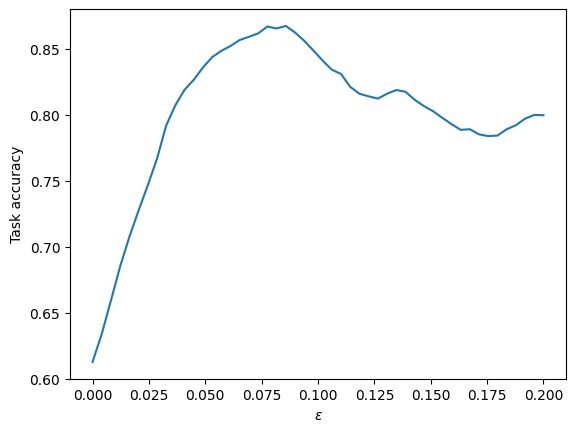

In [7]:
epsilons = np.linspace(0, 0.2)
dsprites_net2vec_epsilon_accuracies = []

for epsilon in epsilons:
  dsprites_net2vec_epsilon_accuracies.append(calculate_accuracy_with_interventions(
    dsprites_model,
    dsprite_concept_classifier,
    dsprites.test_dl,
    epsilon,
    [True, True, True, True, True, True, True]))

plt.plot(epsilons, dsprites_net2vec_epsilon_accuracies)
plt.xlabel("$\epsilon$")
plt.ylabel("Task accuracy")
plt.show()

In [10]:
dsprites_concept_groups_intervened = [0, 1, 2]
dsprites_net2vec_intervention_accuracies = []
dsprites_net2vec_intervention_accuracies.append(calculate_accuracy_with_interventions(
  dsprites_model,
  dsprite_concept_classifier,
  dsprites.test_dl,
  0.09,
  [False, False, False, False, False, False, False]))
dsprites_net2vec_intervention_accuracies.append(calculate_accuracy_with_interventions(
  dsprites_model,
  dsprite_concept_classifier,
  dsprites.test_dl,
  0.09,
  [False, False, False, False, True, True, True]))
dsprites_net2vec_intervention_accuracies.append(calculate_accuracy_with_interventions(
  dsprites_model,
  dsprite_concept_classifier,
  dsprites.test_dl,
  0.09,
  [True, True, True, True, True, True, True]))

In [11]:
dsprites_net2vec_incorrect_intervention_accuracies = []
dsprites_net2vec_incorrect_intervention_accuracies.append(calculate_accuracy_with_interventions(
  dsprites_model,
  dsprite_concept_classifier,
  dsprites.test_dl,
  0.09,
  [False, False, False, False, False, False, False],
  intervene_incorrectly=True))
dsprites_net2vec_incorrect_intervention_accuracies.append(calculate_accuracy_with_interventions(
  dsprites_model,
  dsprite_concept_classifier,
  dsprites.test_dl,
  0.09,
  [False, False, False, False, True, True, True],
  intervene_incorrectly=True))
dsprites_net2vec_incorrect_intervention_accuracies.append(calculate_accuracy_with_interventions(
  dsprites_model,
  dsprite_concept_classifier,
  dsprites.test_dl,
  0.09,
  [True, True, True, True, True, True, True],
  intervene_incorrectly=True))

## MNIST ADD

In [12]:
mnist_model = models.Model(2, 28, 28, 13)

if os.path.exists('mnist_model.pth'):
  mnist_model.load_state_dict(torch.load('mnist_model.pth'))
else:
  train(mnist_model, train_dl(2, (0, 1, 2, 3, 4, 5, 6)), val_dl(2, (0, 1, 2, 3, 4, 5, 6)), epochs=100)
  torch.save(mnist_model.state_dict(), 'mnist_model.pth')
mnist_model.to(device)

Model(
  (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (postconv1): Sequential(
    (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (postconv2): Sequential(
    (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (postconv3): Sequential(
    (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (postconv4): Sequential(
    (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (out): Sequential(
    (0): Flatten(start_dim=1, end

In [13]:
mnist_concept_classifier = models.LinearModels(64, 14)

if os.path.exists('mnist_concept_classifier.pth'):
  mnist_concept_classifier.load_state_dict(torch.load('mnist_concept_classifier.pth'))
else:
  train_concept_classifier(mnist_model, mnist_concept_classifier, train_dl(2, (0, 1, 2, 3, 4, 5, 6)), val_dl(2, (0, 1, 2, 3, 4, 5, 6)))
  torch.save(mnist_concept_classifier.state_dict(), 'mnist_concept_classifier.pth')
mnist_concept_classifier.to(device)

LinearModels(
  (l): Linear(in_features=64, out_features=14, bias=True)
  (sigmoid): Sigmoid()
)

In [14]:
calculate_accuracy(test_dl(2, (0, 1, 2, 3, 4, 5, 6)), mnist_model)

Seed set to 42


0.7507

In [15]:
calculate_concept_accuracy(test_dl(2, (0, 1, 2, 3, 4, 5, 6)), mnist_model, mnist_concept_classifier)

(0.8603,
 array([0.8629, 0.849 , 0.8562, 0.8598, 0.8627, 0.8653, 0.8629, 0.8539,
        0.8699, 0.8512, 0.8575, 0.8595, 0.8758, 0.8576]))

In [16]:
calculate_accuracy_with_interventions(mnist_model, mnist_concept_classifier, test_dl(2, (0, 1, 2, 3, 4, 5, 6)), 0.1, [True] * 14)

0.7486

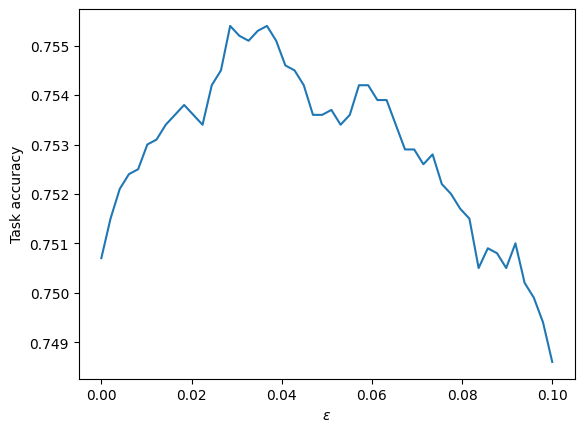

In [17]:
epsilons = np.linspace(0, 0.1)
mnist_net2vec_epsilon_accuracies = []

for epsilon in epsilons:
  mnist_net2vec_epsilon_accuracies.append(calculate_accuracy_with_interventions(
    mnist_model,
    mnist_concept_classifier,
    test_dl(2, (0, 1, 2, 3, 4, 5, 6)),
    epsilon,
    [True] * 14))

plt.plot(epsilons, mnist_net2vec_epsilon_accuracies)
plt.xlabel("$\epsilon$")
plt.ylabel("Task accuracy")
plt.show()

In [18]:
mnist_net2vec_epsilon_accuracies[14]

0.7554

In [19]:
epsilons[14]

0.028571428571428574

In [20]:
mnist_concept_groups_intervened = [0, 1, 2]
mnist_net2vec_intervention_accuracies = []
mnist_net2vec_intervention_accuracies.append(calculate_accuracy_with_interventions(
  mnist_model,
  mnist_concept_classifier,
  test_dl(2, (0, 1, 2, 3, 4, 5, 6)),
  0.03,
  [False] * 14))
mnist_net2vec_intervention_accuracies.append(calculate_accuracy_with_interventions(
  mnist_model,
  mnist_concept_classifier,
  test_dl(2, (0, 1, 2, 3, 4, 5, 6)),
  0.03,
  [True] * 7 + [False] * 7))
mnist_net2vec_intervention_accuracies.append(calculate_accuracy_with_interventions(
  mnist_model,
  mnist_concept_classifier,
  test_dl(2, (0, 1, 2, 3, 4, 5, 6)),
  0.03,
  [True] * 14))

In [21]:
mnist_net2vec_incorrect_intervention_accuracies = []
mnist_net2vec_incorrect_intervention_accuracies.append(calculate_accuracy_with_interventions(
  mnist_model,
  mnist_concept_classifier,
  test_dl(2, (0, 1, 2, 3, 4, 5, 6)),
  0.03,
  [False] * 14,
  intervene_incorrectly=True))
mnist_net2vec_incorrect_intervention_accuracies.append(calculate_accuracy_with_interventions(
  mnist_model,
  mnist_concept_classifier,
  test_dl(2, (0, 1, 2, 3, 4, 5, 6)),
  0.03,
  [True] * 7 + [False] * 7,
  intervene_incorrectly=True))
mnist_net2vec_incorrect_intervention_accuracies.append(calculate_accuracy_with_interventions(
  mnist_model,
  mnist_concept_classifier,
  test_dl(2, (0, 1, 2, 3, 4, 5, 6)),
  0.03,
  [True] * 14,
  intervene_incorrectly=True))

# Baseline 1: CBM

## DSPRITES

In [22]:
dsprites_cbm = models.CBM(1, 64, 64, 7, 12)

if os.path.exists('dsprites_cbm.pth'):
  dsprites_cbm.load_state_dict(torch.load('dsprites_cbm.pth'))
else:
    train_independent_cbm(dsprites_cbm, dsprites.train_dl, epochs=100)
    torch.save(dsprites_cbm.state_dict(), 'dsprites_cbm.pth')
dsprites_cbm.to(device)

CBM(
  (concept_encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=65536, out_features=7, bias=True)
  )
  (label_predictor): Sequential(
    (0): L

In [23]:
calculate_cbm_accuracies(dsprites.test_dl, dsprites_cbm)

(0.08506944444444445, 0.6661086309523809)

In [24]:
dsprites_cbm_intervention_accuracies = []
dsprites_cbm_intervention_accuracies.append(calculate_cbm_accuracies(
  dsprites.test_dl,
  dsprites_cbm,
  [False, False, False, False, False, False, False])[0])
dsprites_cbm_intervention_accuracies.append(calculate_cbm_accuracies(
  dsprites.test_dl,
  dsprites_cbm,
  [False, False, False, False, True, True, True])[0])
dsprites_cbm_intervention_accuracies.append(calculate_cbm_accuracies(
  dsprites.test_dl,
  dsprites_cbm,
  [True, True, True, True, True, True, True])[0])

In [25]:
dsprites_cbm_incorrect_intervention_accuracies = []
dsprites_cbm_incorrect_intervention_accuracies.append(calculate_cbm_accuracies(
  dsprites.test_dl,
  dsprites_cbm,
  [False, False, False, False, False, False, False],
  intervene_incorrectly=True)[0])
dsprites_cbm_incorrect_intervention_accuracies.append(calculate_cbm_accuracies(
  dsprites.test_dl,
  dsprites_cbm,
  [False, False, False, False, True, True, True],
  intervene_incorrectly=True)[0])
dsprites_cbm_incorrect_intervention_accuracies.append(calculate_cbm_accuracies(
  dsprites.test_dl,
  dsprites_cbm,
  [True, True, True, True, True, True, True],
  intervene_incorrectly=True)[0])

## MNIST ADD

In [26]:
mnist_cbm = models.CBM(2, 28, 28, 14, 13)

if os.path.exists('mnist_cbm.pth'):
  mnist_cbm.load_state_dict(torch.load('mnist_cbm.pth'))
else:
  train_independent_cbm(mnist_cbm, train_dl(2, (0, 1, 2, 3, 4, 5, 6)), epochs=100)
  torch.save(mnist_cbm.state_dict(), 'mnist_cbm.pth')
mnist_cbm.to(device)

CBM(
  (concept_encoder): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=12544, out_features=14, bias=True)
  )
  (label_predictor): Sequential(
    (0): 

In [27]:
calculate_cbm_accuracies(test_dl(2, (0, 1, 2, 3, 4, 5, 6)), mnist_cbm)

(0.9639, 0.9937714285714285)

In [28]:
mnist_cbm_intervention_accuracies = []
mnist_cbm_intervention_accuracies.append(calculate_cbm_accuracies(
  test_dl(2, (0, 1, 2, 3, 4, 5, 6)),
  mnist_cbm,
  [False] * 14)[0])
mnist_cbm_intervention_accuracies.append(calculate_cbm_accuracies(
  test_dl(2, (0, 1, 2, 3, 4, 5, 6)),
  mnist_cbm,
  [True] * 7 + [False] * 7)[0])
mnist_cbm_intervention_accuracies.append(calculate_cbm_accuracies(
  test_dl(2, (0, 1, 2, 3, 4, 5, 6)),
  mnist_cbm,
  [True] * 14)[0])

In [29]:
mnist_cbm_incorrect_intervention_accuracies = []
mnist_cbm_incorrect_intervention_accuracies.append(calculate_cbm_accuracies(
  test_dl(2, (0, 1, 2, 3, 4, 5, 6)),
  mnist_cbm,
  [False] * 14,
  intervene_incorrectly=True)[0])
mnist_cbm_incorrect_intervention_accuracies.append(calculate_cbm_accuracies(
  test_dl(2, (0, 1, 2, 3, 4, 5, 6)),
  mnist_cbm,
  [True] * 7 + [False] * 7,
  intervene_incorrectly=True)[0])
mnist_cbm_incorrect_intervention_accuracies.append(calculate_cbm_accuracies(
  test_dl(2, (0, 1, 2, 3, 4, 5, 6)),
  mnist_cbm,
  [True] * 14,
  intervene_incorrectly=True)[0])

# Baseline 2: CEM

## DSPRITES

In [30]:
config = {
  "weight_loss": None,
  "top_k_accuracy": None,
  "emb_size": 16,
  "extra_dims": 0,
  "concept_loss_weight": 1,
  "learning_rate": 0.001,
  "weight_decay": 4e-06,
  "optimizer": "sgd",
  "bool": False,
  "sigmoidal_prob": True,
  "training_intervention_prob": 0.25,
  "intervention_freq": 1,
  "c2y_layers": [128],
  "architecture": "ConceptEmbeddingModel",
  "shared_prob_gen": True,
  "embedding_activation": "leakyrelu",
  "max_epochs": 100,
  "skip_repr_evaluation": True,
  "test_subsampling": 1,
  "use_task_class_weights": True,
  "check_val_every_n_epoch": 2,
  "save_model": True,
  "patience": 10,
  "early_stopping_monitor": "val_loss",
  "early_stopping_mode": "min",
  "early_stopping_delta": 0.0,
  "momentum": 0.9,
  "extra_name": "",
  "sigmoidal_embedding": False,
  "concat_prob": False,
  "imbalance": None,
  "c_extractor_arch": models.get_cem_c_extractor_arch(1, 64, 64),
}

dsprites_cem = training.train_model(
    accelerator="auto",
    devices="auto",
    n_concepts=7,
    n_tasks=12,
    config=config,
    train_dl=dsprites.train_dl,
    val_dl=dsprites.val_dl,
    test_dl=dsprites.test_dl,
    result_dir="dsprites_cem",
    seed=42,
)[0]

Seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[Training ConceptEmbeddingModel_lambda]
config:
	weight_loss -> None
	top_k_accuracy -> None
	emb_size -> 16
	extra_dims -> 0
	concept_loss_weight -> 1
	learning_rate -> 0.001
	weight_decay -> 4e-06
	optimizer -> sgd
	bool -> False
	sigmoidal_prob -> True
	training_intervention_prob -> 0.25
	intervention_freq -> 1
	c2y_layers -> [128]
	architecture -> ConceptEmbeddingModel
	shared_prob_gen -> True
	embedding_activation -> leakyrelu
	max_epochs -> 100
	skip_repr_evaluation -> True
	test_subsampling -> 1
	use_task_class_weights -> True
	check_val_every_n_epoch -> 2
	save_model -> True
	patience -> 10
	early_stopping_monitor -> val_loss
	early_stopping_mode -> min
	early_stopping_delta -> 0.0
	momentum -> 0.9
	extra_name -> 
	sigmoidal_embedding -> False
	concat_prob -> False
	imbalance -> None
	c_extractor_arch -> <function get_cem_c_extractor_arch.<locals>.c_extractor_arch at 0x31549b5e0>
[Number of parameters in model 8440925 ]
[Number of non-trainable parameters in model 0 ]
	Found ca

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    test_avg_c_y_acc         0.999395489692688
     test_c_accuracy        0.9994419813156128
       test_c_auc           0.9989444017410278
        test_c_f1           0.9992597103118896
    test_concept_loss      0.005141783505678177
        test_loss           0.00742351682856679
     test_task_loss        0.0022817333228886127
     test_y_accuracy        0.9993489384651184
       test_y_auc                   1.0
        test_y_f1           0.9993489384651184
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
c_acc: 99.94%, y_acc: 99.93%, c_auc: 99.89%, y_auc: 100.00% with 100.0 epochs in 344.59 seconds


In [31]:
calculate_cem_accuracies(dsprites.test_dl, dsprites_cem)

(0.9993489583333334, 0.9994419642857143)

In [32]:
dsprites_cem_intervention_accuracies = []
dsprites_cem_intervention_accuracies.append(calculate_cem_accuracies(
  dsprites.test_dl,
  dsprites_cem,
  [False, False, False, False, False, False, False])[0])
dsprites_cem_intervention_accuracies.append(calculate_cem_accuracies(
  dsprites.test_dl,
  dsprites_cem,
  [False, False, False, False, True, True, True])[0])
dsprites_cem_intervention_accuracies.append(calculate_cem_accuracies(
  dsprites.test_dl,
  dsprites_cem,
  [True, True, True, True, True, True, True])[0])

In [33]:
dsprites_cem_incorrect_intervention_accuracies = []
dsprites_cem_incorrect_intervention_accuracies.append(calculate_cem_accuracies(
  dsprites.test_dl,
  dsprites_cem,
  [False, False, False, False, False, False, False],
  intervene_incorrectly=True)[0])
dsprites_cem_incorrect_intervention_accuracies.append(calculate_cem_accuracies(
  dsprites.test_dl,
  dsprites_cem,
  [False, False, False, False, True, True, True],
  intervene_incorrectly=True)[0])
dsprites_cem_incorrect_intervention_accuracies.append(calculate_cem_accuracies(
  dsprites.test_dl,
  dsprites_cem,
  [True, True, True, True, True, True, True],
  intervene_incorrectly=True)[0])

## MNIST-ADD

In [34]:
config = {
  "weight_loss": None,
  "top_k_accuracy": None,
  "emb_size": 16,
  "extra_dims": 0,
  "concept_loss_weight": 1,
  "learning_rate": 0.001,
  "weight_decay": 4e-06,
  "optimizer": "sgd",
  "bool": False,
  "sigmoidal_prob": True,
  "training_intervention_prob": 0.25,
  "intervention_freq": 1,
  "c2y_layers": [128],
  "architecture": "ConceptEmbeddingModel",
  "shared_prob_gen": True,
  "embedding_activation": "leakyrelu",
  "max_epochs": 100,
  "skip_repr_evaluation": True,
  "test_subsampling": 1,
  "use_task_class_weights": True,
  "check_val_every_n_epoch": 2,
  "save_model": True,
  "patience": 10,
  "early_stopping_monitor": "val_loss",
  "early_stopping_mode": "min",
  "early_stopping_delta": 0.0,
  "momentum": 0.9,
  "extra_name": "",
  "sigmoidal_embedding": False,
  "concat_prob": False,
  "imbalance": None,
  "c_extractor_arch": models.get_cem_c_extractor_arch(2, 28, 28),
}

mnist_cem = training.train_model(
    accelerator="auto",
    devices="auto",
    n_concepts=14,
    n_tasks=13,
    config=config,
    train_dl=train_dl(2, (0, 1, 2, 3, 4, 5, 6)),
    val_dl=val_dl(2, (0, 1, 2, 3, 4, 5, 6)),
    test_dl=test_dl(2, (0, 1, 2, 3, 4, 5, 6)),
    result_dir="mnist_cem",
    seed=42,
)[0]

Seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[Training ConceptEmbeddingModel_lambda]
config:
	weight_loss -> None
	top_k_accuracy -> None
	emb_size -> 16
	extra_dims -> 0
	concept_loss_weight -> 1
	learning_rate -> 0.001
	weight_decay -> 4e-06
	optimizer -> sgd
	bool -> False
	sigmoidal_prob -> True
	training_intervention_prob -> 0.25
	intervention_freq -> 1
	c2y_layers -> [128]
	architecture -> ConceptEmbeddingModel
	shared_prob_gen -> True
	embedding_activation -> leakyrelu
	max_epochs -> 100
	skip_repr_evaluation -> True
	test_subsampling -> 1
	use_task_class_weights -> True
	check_val_every_n_epoch -> 2
	save_model -> True
	patience -> 10
	early_stopping_monitor -> val_loss
	early_stopping_mode -> min
	early_stopping_delta -> 0.0
	momentum -> 0.9
	extra_name -> 
	sigmoidal_embedding -> False
	concat_prob -> False
	imbalance -> None
	c_extractor_arch -> <function get_cem_c_extractor_arch.<locals>.c_extractor_arch at 0x31653d3a0>
[Number of parameters in model 1701454 ]
[Number of non-trainable parameters in model 0 ]
	Found ca

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    test_avg_c_y_acc        0.7434607148170471
     test_c_accuracy        0.8909214735031128
       test_c_auc           0.7055792808532715
        test_c_f1           0.7290427088737488
    test_concept_loss       0.2471648007631302
        test_loss           1.4622472524642944
     test_task_loss         1.2150826454162598
     test_y_accuracy        0.5960000157356262
       test_y_auc           0.9482746124267578
        test_y_f1           0.6396666169166565
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
c_acc: 89.09%, y_acc: 59.60%, c_auc: 70.56%, y_auc: 94.83% with 100.0 epochs in 78.54 seconds


In [35]:
calculate_cem_accuracies(test_dl(2, (0, 1, 2, 3, 4, 5, 6)), mnist_cem)

(0.596, 0.8909214285714285)

In [36]:
mnist_cem_intervention_accuracies = []
mnist_cem_intervention_accuracies.append(calculate_cem_accuracies(
  test_dl(2, (0, 1, 2, 3, 4, 5, 6)),
  mnist_cem,
  [False] * 14)[0])
mnist_cem_intervention_accuracies.append(calculate_cem_accuracies(
  test_dl(2, (0, 1, 2, 3, 4, 5, 6)),
  mnist_cem,
  [True] * 7 + [False] * 7)[0])
mnist_cem_intervention_accuracies.append(calculate_cem_accuracies(
  test_dl(2, (0, 1, 2, 3, 4, 5, 6)),
  mnist_cem,
  [True] * 14)[0])

In [37]:
mnist_cem_incorrect_intervention_accuracies = []
mnist_cem_incorrect_intervention_accuracies.append(calculate_cem_accuracies(
  test_dl(2, (0, 1, 2, 3, 4, 5, 6)),
  mnist_cem,
  [False] * 14,
  intervene_incorrectly=True)[0])
mnist_cem_incorrect_intervention_accuracies.append(calculate_cem_accuracies(
  test_dl(2, (0, 1, 2, 3, 4, 5, 6)),
  mnist_cem,
  [True] * 7 + [False] * 7,
  intervene_incorrectly=True)[0])
mnist_cem_incorrect_intervention_accuracies.append(calculate_cem_accuracies(
  test_dl(2, (0, 1, 2, 3, 4, 5, 6)),
  mnist_cem,
  [True] * 14,
  intervene_incorrectly=True)[0])

# Graphs

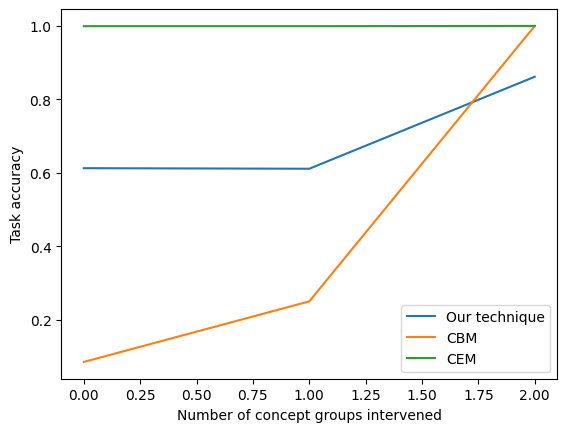

In [38]:
plt.plot(
  dsprites_concept_groups_intervened,
  dsprites_net2vec_intervention_accuracies, label="Our technique"
)
plt.plot(
  dsprites_concept_groups_intervened,
  dsprites_cbm_intervention_accuracies,
  label="CBM"
)
plt.plot(
  dsprites_concept_groups_intervened,
  dsprites_cem_intervention_accuracies,
  label="CEM"
)
plt.legend()
plt.xlabel("Number of concept groups intervened")
plt.ylabel("Task accuracy")
plt.show()

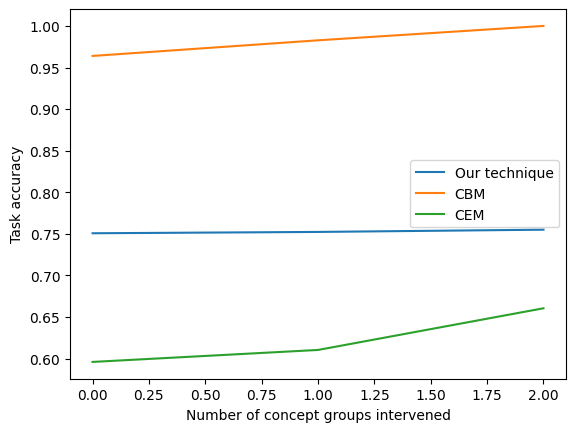

In [39]:
plt.plot(
  mnist_concept_groups_intervened,
  mnist_net2vec_intervention_accuracies, label="Our technique"
)
plt.plot(
  mnist_concept_groups_intervened,
  mnist_cbm_intervention_accuracies,
  label="CBM"
)
plt.plot(
  mnist_concept_groups_intervened,
  mnist_cem_intervention_accuracies,
  label="CEM"
)
plt.legend()
plt.xlabel("Number of concept groups intervened")
plt.ylabel("Task accuracy")
plt.show()

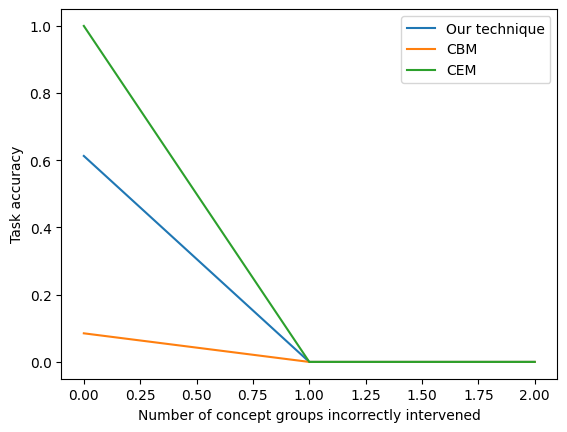

In [40]:
plt.plot(
  dsprites_concept_groups_intervened,
  dsprites_net2vec_incorrect_intervention_accuracies, label="Our technique"
)
plt.plot(
  dsprites_concept_groups_intervened,
  dsprites_cbm_incorrect_intervention_accuracies,
  label="CBM"
)
plt.plot(
  dsprites_concept_groups_intervened,
  dsprites_cem_incorrect_intervention_accuracies,
  label="CEM"
)
plt.legend()
plt.xlabel("Number of concept groups incorrectly intervened")
plt.ylabel("Task accuracy")
plt.show()

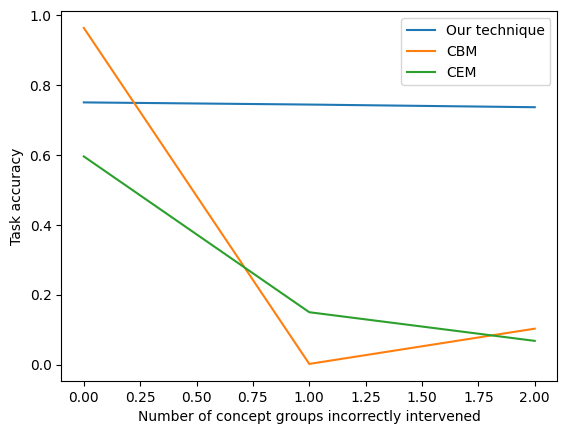

In [41]:
plt.plot(
  mnist_concept_groups_intervened,
  mnist_net2vec_incorrect_intervention_accuracies, label="Our technique"
)
plt.plot(
  mnist_concept_groups_intervened,
  mnist_cbm_incorrect_intervention_accuracies,
  label="CBM"
)
plt.plot(
  mnist_concept_groups_intervened,
  mnist_cem_incorrect_intervention_accuracies,
  label="CEM"
)
plt.legend()
plt.xlabel("Number of concept groups incorrectly intervened")
plt.ylabel("Task accuracy")
plt.show()

In [42]:
mnist_net2vec_incorrect_intervention_accuracies

[0.7507, 0.7445, 0.7369]